In [19]:
import numpy as np
import matplotlib.patches as mpatches
import copy
import json

import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=15,family='serif')
# plt.style.use('matplotlibrc')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
# plt.style.use('tableau-colorblind10')

%matplotlib inline

np.set_printoptions(linewidth=1000)

receptor_labels = np.loadtxt("DoOR_datasets/receptor_labels.txt", dtype='str', delimiter=',')
odorant_labels = np.genfromtxt("DoOR_datasets/odorant_labels.txt", dtype='str', delimiter='\n')
# # For the DoOR datasets, the odorant labels are also provided by their InChIKey
# odorant_labels = np.loadtxt("DoOR_datasets/odorant_labels_InChIKey.txt", dtype='str', delimiter=',')
receptor_responses = np.loadtxt("DoOR_datasets/receptor_responses.csv", delimiter=',')

# exclude all receptors which are not Or
Or_receptor_idx = np.where(np.char.find(receptor_labels, 'Or') == 0)[0]
receptor_labels = receptor_labels[Or_receptor_idx]
receptor_responses = receptor_responses[:,Or_receptor_idx]

In [20]:
assert receptor_responses.shape == (len(odorant_labels), len(receptor_labels))
receptor_responses.shape

(694, 52)

# Analyse odor/OR space

In [21]:
# calculate separability of response matrix
def separability(response_mat):
    sep = 0.0
    # for each pair of rows (= odors)
    for i in range(response_mat.shape[0]):
        for j in range(response_mat.shape[0]):
            if i == j:
                continue
            # calculate distance between odor responses
            sep += np.linalg.norm(response_mat[i] - response_mat[j])
    return sep

def reduce_ORs(data, n_rec_max):

    # take full data matrix (selected odors x all receptors)
    reduced_data = data.copy()
    selected_receptor_idx = np.arange(data.shape[1])
    
    # if n_rec_max is already same as number of ORs (before reduction)
    if len(selected_receptor_idx) == n_rec_max:
        return reduced_data, selected_receptor_idx

    while len(selected_receptor_idx) != n_rec_max:
        # reduce data matrix by one receptor and calculate distance
        sep_arr = []
        for i, rec_id in enumerate(selected_receptor_idx):
            # kill one receptor
            temp_reduced_data = reduced_data.copy()
            temp_reduced_data[:, i] = 0
            # calculate separability of newly reduced data
            sep_arr.append(separability(temp_reduced_data))

        # eliminate receptor that leaves the dataset with the highest separability
        sep_arr = np.array(sep_arr)
        selected_receptor_idx = np.delete(selected_receptor_idx, np.argmax(sep_arr))
        reduced_data = np.delete(reduced_data, np.argmax(sep_arr), axis=1)
    
    return reduced_data, selected_receptor_idx

## Example analysis

In [22]:
# odor sets we want to investigate
od_names = ['none', 'methanol', 'propyl acetate', 'cadaverine']

# how many receptors we want to reconstitute
N_OR = 7

In [23]:
# convert odorant names into idx
od_idx = np.array([np.where(odorant_labels == od_name) for od_name in od_names]).flatten()

print(f"Performing analysis for odorants {od_idx}:")
for od_id in od_idx:
    print(str(odorant_labels[od_id]))

reduced_data, selected_receptor_idx = reduce_ORs(receptor_responses[od_idx], N_OR)

print("\nBest receptors for N_OR =", N_OR, ":")
print("Selected receptor idx:", selected_receptor_idx)
print("Selected receptors:", receptor_labels[selected_receptor_idx], '\n')

Performing analysis for odorants [693 131 164   4]:
none
methanol
propyl acetate
cadaverine

Best receptors for N_OR = 7 :
Selected receptor idx: [ 7 17 18 20 24 40 49]
Selected receptors: ['Or22a' 'Or42a' 'Or42b' 'Or43b' 'Or47a' 'Or85b' 'Or98a'] 



## Generate odor space analysis figure from paper:

In [24]:
# odor sets we want to investigate
od_names_list = [['none', 'methanol', 'propyl acetate', 'gamma-butyrolactone'],
                 ['none', 'methanol', 'benzyl alcohol', '2,3-butanediol'],
                 ['none', 'methanol', 'ethanol', '1-propanol']]

In [29]:
n_rec_sep_arr_list = []
od_idx_list = []
selected_receptors_list = []

for od_names in od_names_list:
    od_idx = np.array([np.where(odorant_labels == od_name) for od_name in od_names]).flatten()
    od_idx_list.append(od_idx)

    print(f"Performing analysis for odorants {od_idx}:")
    for od_id in od_idx:
        print(str(odorant_labels[od_id]), end =" ")
    print("\n")

    n_rec_sep_arr = []
    for n_rec_max in np.arange(len(receptor_responses[0]), 0, -1):
        full_data = receptor_responses[od_idx]
        reduced_data, selected_receptor_idx = reduce_ORs(full_data, n_rec_max)
#         n_rec_sep_arr.append(separability(reduced_data)/separability(full_data))
        n_rec_sep_arr.append(separability(reduced_data)) # do not normalize in order to compare with other odorants

        if n_rec_max == 3:
            print("Current number of receptors: ", n_rec_max)
            print("Selected receptor idx:", selected_receptor_idx)
            print("Selected receptors:", receptor_labels[selected_receptor_idx])
            print("Responses of selected receptors:\n", reduced_data, '\n')
            selected_receptors_list.append(receptor_labels[selected_receptor_idx])

    n_rec_sep_arr_list.append(n_rec_sep_arr)

# normalize full results (over multiple od_names)
n_rec_sep_arr_list = np.array(n_rec_sep_arr_list)
n_rec_sep_arr_list = n_rec_sep_arr_list/np.max(n_rec_sep_arr_list)




Performing analysis for odorants [693 131 164  10]:
none methanol propyl acetate gamma-butyrolactone 

Current number of receptors:  3
Selected receptor idx: [16 17 18]
Selected receptors: ['Or35a' 'Or42a' 'Or42b']
Responses of selected receptors:
 [[0.         0.         0.        ]
 [0.18476624 0.         0.        ]
 [0.41241934 0.89735383 0.70744697]
 [0.32210266 0.         0.        ]] 

Performing analysis for odorants [693 131  97 149]:
none methanol benzyl alcohol 2,3-butanediol 

Current number of receptors:  3
Selected receptor idx: [ 3 33 46]
Selected receptors: ['Or9a' 'Or67b' 'Or92a']
Responses of selected receptors:
 [[0.         0.         0.        ]
 [0.15147615 0.         0.        ]
 [0.16562881 0.68727683 0.01056946]
 [0.62145427 0.25139821 0.49088645]] 

Performing analysis for odorants [693 131 132 133]:
none methanol ethanol 1-propanol 

Current number of receptors:  3
Selected receptor idx: [ 2  7 16]
Selected receptors: ['Or7a' 'Or22a' 'Or35a']
Responses of sel

none, methanol, propyl acetate, $\gamma$-butyrolactone
best receptors:
Or35a, Or42a, Or42b
none, methanol, benzyl alcohol, 2,3-butanediol
best receptors:
Or9a, Or67b, Or92a
none, methanol, ethanol, 1-propanol
best receptors:
Or7a, Or22a, Or35a


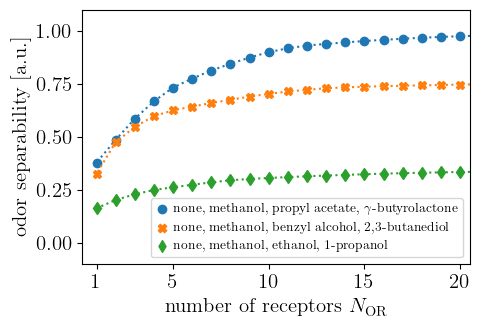

In [18]:
plt.figure(figsize=(5,3.3))

for i, (n_rec_sep_arr, od_names, marker) in enumerate(zip(n_rec_sep_arr_list, od_names_list, ['o', 'X', 'd'])):

    title = ""
    for odr_title in od_names[:-1]:
#         if odr_title == 'none':
#             continue
        title +=  str(odr_title) + ', '
    if od_names[-1] == 'gamma-butyrolactone':
        od_names[-1] = '$\gamma$-butyrolactone'
    title +=  str(od_names[-1])
    plt.plot(np.arange(len(receptor_responses[0]), 0, -1), n_rec_sep_arr, marker=marker, ls=':', c='C'+str(i))
    plt.scatter([None], [None], label=title, marker=marker, c='C'+str(i))
    print(title)
    print('best receptors:')
    print(', '.join(map(str, selected_receptors_list[i])))
    
   
# plt.title(title)
plt.xlabel("number of receptors $N_\\mathrm{OR}$")
plt.ylabel("odor separability [a.u.]")
plt.xticks(np.append([1], np.arange(0, len(receptor_responses[0]), 5)))
plt.xlim(0.25, len(receptor_labels)+0.75-32.25)
plt.ylim(-0.1, 1.1)
# plt.ylim(0, 4.02)
# plt.tight_layout()
leg = plt.legend(loc='lower right', prop={'size': 9.5}, borderpad=0.4, handletextpad=0.3, handlelength=1.0)

for t in leg.get_texts():
    t.set_verticalalignment("baseline")

out_name = np.array(od_idx_list).ravel()
out_name = 'od_idx_' + '_'.join(map(str, out_name))

plt.savefig('output/odor_space_analysis/' + out_name + '.pdf',bbox_inches='tight')
plt.show()



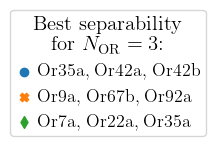

In [9]:
plt.figure(figsize=(1.5,1.5))

for selected_receptors, marker in zip(selected_receptors_list, ['o', 'X', 'd']):
    
    plt.scatter(np.NaN, np.NaN, label=', '.join(map(str, selected_receptors)), marker=marker)
#     plt.bar(np.arange(len(receptor_responses[0]), 0, -1), n_rec_sep_arr, label=title)
        
# plt.title(title)
# plt.xlabel("number of receptors")
# plt.ylabel("odor separability [a.u.]")
# plt.xticks(np.arange(1, len(receptor_responses[0]), 5))
# plt.xlim(0.25, len(receptor_labels)+0.75-50)
# plt.ylim(0, 1.02)
# plt.ylim(0, 4.02)
plt.axis('off')
plt.tight_layout()
l = plt.legend(title='Best separability \n for $N_\\mathrm{OR} = 3$:', loc='lower right', prop={'size': 13}, borderpad=0.3, handletextpad=0.2, handlelength=1.0)
plt.setp(l.get_title(), multialignment='center')

for t in l.get_texts():
    t.set_verticalalignment("baseline")

out_name = np.array(od_idx_list).ravel()
out_name = 'od_idx_' + '_'.join(map(str, out_name))

plt.savefig('output/odor_space_analysis/' + out_name + '_ORs.pdf',bbox_inches='tight')
plt.show()

In [14]:
len(receptor_labels)

52